In [3]:
%matplotlib inline
#for colab !pip install dipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 48.3 MB/s eta 0:00:00




# Introduction to Basic Tracking

Local fiber tracking is an approach used to model white matter fibers by
creating streamlines from local directional information. The idea is as
follows: if the local directionality of a tract/pathway segment is known, one
can integrate along those directions to build a complete representation of that
structure. Local fiber tracking is widely used in the field of diffusion MRI
because it is simple and robust.

In order to perform local fiber tracking, three things are needed: 1) A method
for getting directions from a diffusion data set. 2) A method for identifying
when the tracking must stop. 3) A set of seeds from which to
begin tracking. This example shows how to combine the 3 parts described above
to create a tractography reconstruction from a diffusion data set.


To begin, let's load an example HARDI data set from Stanford. If you have
not already downloaded this data set, the first time you run this example you
will need to be connected to the internet and this dataset will be downloaded
to your computer.



In [4]:
# Enables/disables interactive visualization
interactive = False

from dipy.core.gradients import gradient_table
from dipy.data import get_fnames
from dipy.io.gradients import read_bvals_bvecs
from dipy.io.image import load_nifti, load_nifti_data

hardi_fname, hardi_bval_fname, hardi_bvec_fname = get_fnames('stanford_hardi')
label_fname = get_fnames('stanford_labels')

data, affine, hardi_img = load_nifti(hardi_fname, return_img=True)
labels = load_nifti_data(label_fname)
bvals, bvecs = read_bvals_bvecs(hardi_bval_fname, hardi_bvec_fname)
gtab = gradient_table(bvals, bvecs)

  0%|          | 0/5578 [00:00<?, ? MB/s]

  0%|          | 0/1 [00:00<?, ? MB/s]

  0%|          | 0/1 [00:00<?, ? MB/s]

  0%|          | 0/4 [00:00<?, ? MB/s]

  0%|          | 0/1 [00:00<?, ? MB/s]

This dataset provides a label map in which all white matter tissues are
labeled either 1 or 2. Let's create a white matter mask to restrict tracking to
the white matter.



In [5]:
white_matter = (labels == 1) | (labels == 2)

1. The first thing we need to begin fiber tracking is a way of getting
directions from this diffusion data set. In order to do that, we can fit the
data to a Constant Solid Angle ODF Model. This model will estimate the
Orientation Distribution Function (ODF) at each voxel. The ODF is the
distribution of water diffusion as a function of direction. The peaks of an ODF
are good estimates for the orientation of tract segments at a point in the
image. Here, we use ``peaks_from_model`` to fit the data and calculate the
fiber directions in all voxels of the white matter.



In [6]:
from dipy.reconst.csdeconv import auto_response_ssst
from dipy.reconst.shm import CsaOdfModel
from dipy.data import default_sphere
from dipy.direction import peaks_from_model

response, ratio = auto_response_ssst(gtab, data, roi_radii=10, fa_thr=0.7)
csa_model = CsaOdfModel(gtab, sh_order=6)
csa_peaks = peaks_from_model(csa_model, data, default_sphere,
                             relative_peak_threshold=.8,
                             min_separation_angle=45,
                             mask=white_matter)

For quality assurance we can also visualize a slice from the direction field
which we will use as the basis to perform the tracking. The visualization will
be done using the ``fury`` python package



In [10]:
#for colab !pip install fury

from dipy.viz import window, actor, has_fury

if has_fury:
    scene = window.Scene()
    scene.add(actor.peak_slicer(csa_peaks.peak_dirs,
                                csa_peaks.peak_values,
                                colors=None))

    window.record(scene, out_path='csa_direction_field.png', size=(900, 900))

    if interactive:
        window.show(scene, size=(800, 800))

Found existing installation: fury 0.9.0
Uninstalling fury-0.9.0:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/fury-0.9.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/fury/*
Proceed (Y/n)? Y
  Successfully uninstalled fury-0.9.0
  Using cached fury-0.9.0-py3-none-any.whl (510 kB)


ImportError: ignored

.. figure:: csa_direction_field.png
 :align: center

 **Direction Field (peaks)**



2. Next we need some way of restricting the fiber tracking to areas with good
directionality information. We've already created the white matter mask,
but we can go a step further and restrict fiber tracking to those areas where
the ODF shows significant restricted diffusion by thresholding on
the generalized fractional anisotropy (GFA).



In [11]:
from dipy.tracking.stopping_criterion import ThresholdStoppingCriterion

stopping_criterion = ThresholdStoppingCriterion(csa_peaks.gfa, .25)

Again, for quality assurance, we can also visualize a slice of the GFA and the
resulting tracking mask.



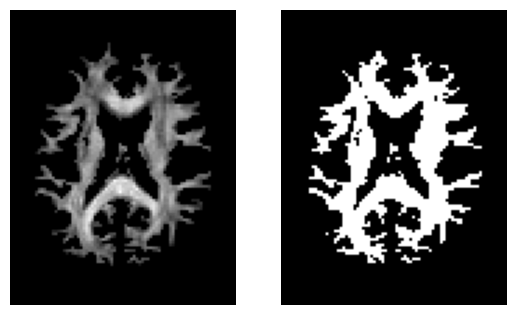

In [12]:
import matplotlib.pyplot as plt

sli = csa_peaks.gfa.shape[2] // 2
plt.figure('GFA')
plt.subplot(1, 2, 1).set_axis_off()
plt.imshow(csa_peaks.gfa[:, :, sli].T, cmap='gray', origin='lower')

plt.subplot(1, 2, 2).set_axis_off()
plt.imshow((csa_peaks.gfa[:, :, sli] > 0.25).T, cmap='gray', origin='lower')

plt.savefig('gfa_tracking_mask.png')

.. figure:: gfa_tracking_mask.png
   :align: center

   An example of a tracking mask derived from the generalized fractional
   anisotropy (GFA).



3. Before we can begin tracking, we need to specify where to "seed" (begin)
the fiber tracking. Generally, the seeds chosen will depend on the pathways
one is interested in modeling. In this example, we'll use a $2 \times 2 \times
2$ grid of seeds per voxel, in a sagittal slice of the corpus callosum.
Tracking from this region will give us a model of the corpus callosum tract.
This slice has label value ``2`` in the label's image.



In [13]:
from dipy.tracking import utils

seed_mask = (labels == 2)
seeds = utils.seeds_from_mask(seed_mask, affine, density=[2, 2, 2])

Finally, we can bring it all together using ``LocalTracking``, using
the EuDX algorithm [Garyfallidis12]_. ``EuDX`` [Garyfallidis12]_ is a fast
algorithm that we use here to generate streamlines. This algorithm is what is
used here and the default option when providing the output of peaks directly
in LocalTracking.



In [14]:
from dipy.tracking.local_tracking import LocalTracking
from dipy.tracking.streamline import Streamlines

# Initialization of LocalTracking. The computation happens in the next step.
streamlines_generator = LocalTracking(csa_peaks, stopping_criterion, seeds,
                                      affine=affine, step_size=.5)
# Generate streamlines object
streamlines = Streamlines(streamlines_generator)

We will then display the resulting streamlines using the ``fury``
python package.



In [15]:
from dipy.viz import colormap

if has_fury:
    # Prepare the display objects.
    color = colormap.line_colors(streamlines)

    streamlines_actor = actor.line(streamlines,
                                   colormap.line_colors(streamlines))

    # Create the 3D display.
    scene = window.Scene()
    scene.add(streamlines_actor)

    # Save still images for this static example. Or for interactivity use
    window.record(scene, out_path='tractogram_EuDX.png', size=(800, 800))
    if interactive:
        window.show(scene)

ImportError: ignored

.. figure:: tractogram_EuDX.png
   :align: center

   **Corpus Callosum using EuDx**

We've created a deterministic set of streamlines using the EuDX algorithm. This
is so called deterministic because if you repeat the fiber tracking (keeping
all the inputs the same) you will get exactly the same set of streamlines.
We can save the streamlines as a Trackvis file so it can be loaded into other
software for visualization or further analysis.



In [16]:
from dipy.io.stateful_tractogram import Space, StatefulTractogram
from dipy.io.streamline import save_trk

sft = StatefulTractogram(streamlines, hardi_img, Space.RASMM)
save_trk(sft, "tractogram_EuDX.trk", streamlines)

## References
.. [Garyfallidis12] Garyfallidis E., "Towards an accurate brain tractography",
PhD thesis, University of Cambridge, 2012.





Now check what you have done on trackvis.

If you are on Ubuntu. Trackvis might have some issues.

Try this:

sudo apt-get install libjpeg62

sudo add-apt-repository ppa:linuxuprising/libpng12
sudo apt update
sudo apt install libpng12-0

